In [1]:
import numpy as np
%pylab 
rcParams['figure.figsize'] = 12,8
from numba import jit

import copy
import networkx as nx

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Random Matrix Generation 

In [2]:
def getRandomConnectivity(N, pct_connected):
    #Directed mapping
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1 #i connects to j
                else:
                    M[i,j] = 0
    return M

### k-core functions 

In [3]:
def hasKcore(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            
            return False
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return True
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)

            
# TODO get Kcore indices 

def largestKcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    while (hasKcore(M,k)):
        k = k+1
        
    return k - 1
        
    
    
def largestkcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    s=1
    while (s==1):
        
        X = M.copy()
        while(True):
            cur_num_nodes = X.shape[0]
            s = np.sum(X, 0)
            nodes_to_delete = np.where(s < k)[0]
            if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
            
                s=0
                break
            elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
                s=1
                break
            else:
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
        k = k+1
        
    return k - 1

#TODO: Instead of deleting nodes, put 0's on all the connections for the rows and columns that are disconnected
    #Keeps number of all neurons the same so that neuron 3 doesnt become neuron 2 etc. 
    #Look for neurons not in Kcore which are firing and neurons that are in kcore and not firing. 
def kcoreitself(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            # nothing has at least k connections
            return X
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return X
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)



#here we get the largest connected component of  the graph

def largestcomponent(l,N):
    n=np.random.randint(0,N)
    
    boundary=[n]
    b=1
    comp=[n]
    c=1
   
    while(b>0):
        a=boundary.pop()
        
        oldvertex=int(a)
        
        deg=l[oldvertex,0]
        degree=int(deg)
        #print(degree)
        for j in range(degree):
            newvertex=l[oldvertex,j+1]
            q=comp.count(newvertex)
            #print(newvertex)
            q=int(q)
            #print(q)
            if (q==0):
                comp.append(newvertex)
                boundary.append(newvertex)
                #print(newvertex)
                #print(boundary)
            
        b=len(boundary)
            
    #sizeofcomp=len(comp)
    return(comp)

def matrixOfEdges(M,N):
    N = int(N)
    E=np.zeros(N**2).reshape(N,N)  #prepare array with zeros
    k=np.sum(M,0) #array with degree of each vertex
    for i in range(N):
        a=int(k[i]) #degree of the current vertex
        E[i,0]=a  #we put it to the zero row of matrix of edges
    for i in range(N):
        a=int(k[i])
        q=1
        for j in range(N):
            if (M[j,i]==1):
                E[i,q]=j #all the next elements in current column are number of vertices current vertex is connected to
                q=q+1
    return(E)

### Classification Functions

In [4]:
def cut(C): # Mihai ~ Removed unnecessary for loop 
    return C[int(0.9*len(C)):] #we take the second half of the time, when trajectory is close to SO, H,Q or chaos

def deriv(X):  #just a derivative
    N=len(X)
    if N == 0: 
        return []
    d=zeros(N-1)
    for i in range(N-1):
        d[i]=X[i+1]-X[i]
    return d

def muldev(X): #it is like a derivative but multiplication instead of difference
    N=len(X)
    md = zeros(N-1)
    for i in range(N-1):
        md[i]=X[i+1]*X[i]
    return md

def classifier(C1, timetolerance, Ctolerance):
    C=cut(C1) #we look at the second half when it closer to the cycle or whatever it is
    N=len(C)
    countermax=0
    countermin=0
    Cprime=deriv(C)
    Cmd=muldev(Cprime)
    Cpp = deriv(Cprime)
    for i in range(N-2):
        if (Cmd[i]<0): #if sign of derivative changes it means that it max or min
            if (Cpp[i]>0): #if second derivative > 0 it is min
                countermin=countermin+1
            else:
                countermax=countermax+1 # else it is max
    
    max_C = max(C[int(.75*N):N])
    min_C = min(C[int(.75*N):N])
    
    #print(max_C, ",", min_C)
    
    if ((max_C - min_C) < Ctolerance):
        return 2
    
    if ((countermin == 0) and (countermax == 0)):
        return 2
    
    maximums=np.zeros(countermax)
    minimums=np.zeros(countermin)
    maxtimes=np.zeros(countermax)
    mintimes=np.zeros(countermin)
    qmax=0 #counter of max
    qmin=0 #counter of min
    for i in range(N-2):
        if (Cmd[i]<0):
            if (Cpp[i]>0):
                mintimes[qmin]=i #the time when min occurs
                minimums[qmin]=C[i] #the value
                qmin=qmin+1 
            else:
                maxtimes[qmax]=i #the same story for max
                maximums[qmax]=C[i]
                qmax=qmax+1
    
    ### Mihai ~ ADDED TEMPORARY MAGIC NUMBERS TO FIX OFF BY 1 ### 
    min_dim = min(len(maxtimes),len(mintimes))
    maxtimes = maxtimes[:min_dim]
    mintimes = mintimes[:min_dim]
    
    minperiods=deriv(mintimes)
    maxperiods=deriv(maxtimes)
    #print(minperiods)
    #print(maxperiods)

    if(len(maxtimes)+len(mintimes)-2 < 2):  #if the period is too long #Mihai ~ Changed to .any(), but formulation is ambiguous
        print('Increase observation time N*dt')
        return(-1) #-1 is error 
    
    
    checker=1    #we will check conditions for this stuff to be cycle, not chaos. If at lest one of them fails, we put checker to 0
    avper=(sum(minperiods)+sum(maxperiods))*1.0/(countermin+countermax-2) #average period
    #print(avper)
    #print(minimums)
    #print(maximums)
    avmin=sum(minimums)*1.0/countermin #average value of minimum
    avmax=sum(maximums)*1.0/countermax #average value of maximum
    if (avmax-avmin<Ctolerance):
        return(2) #if the difference between min and max smaller than tolerance it is fixed point
    #for i in range(countermin-1):
    for i in range(countermin-2):
        if (abs(minperiods[i]-avper)>timetolerance): #if the deviation from the average larger than the tolerance
            checker=0 #than it is not SO
    #for i in range(countermax-1):
    for i in range(countermax-2):
        if (abs(maxperiods[i]-avper)>timetolerance):
            checker=0
    for i in range(countermin):
        if (abs(minimums[i]-avmin)>Ctolerance):
            checker=0
    for i in range(countermax):
        if (abs(maximums[i]-avmax)>Ctolerance):
            checker=0
    return(checker) #1 is SO, 0 is chaos. 2 is fixed point. -1 is error. 

def classifier2(C1, timetolerance, Ctolerance):
    C=cut(C1) #we look at the second half when it closer to the cycle or whatever it is
    N=len(C)
    countermax=0
    countermin=0
    Cprime=deriv(C)
    Cmd=muldev(Cprime)
    Cpp = deriv(Cprime)
    for i in range(N-2):
        if (Cmd[i]<0): #if sign of derivative changes it means that it max or min
            if (Cpp[i]>0): #if second derivative > 0 it is min
                countermin=countermin+1
            else:
                countermax=countermax+1 # else it is max
    maximums=np.zeros(countermax)
    minimums=np.zeros(countermin)
    maxtimes=np.zeros(countermax)
    mintimes=np.zeros(countermin)
    qmax=0 #counter of max
    qmin=0 #counter of min
    for i in range(N-2):
        if (Cmd[i]<0):
            if (Cpp[i]>0):
                mintimes[qmin]=i #the time when min occurs
                minimums[qmin]=C[i] #the value
                qmin=qmin+1 
            else:
                maxtimes[qmax]=i #the same story for max
                maximums[qmax]=C[i]
                qmax=qmax+1
    
    ### Mihai ~ ADDED TEMPORARY MAGIC NUMBERS TO FIX OFF BY 1 ### 
    min_dim = min(len(maxtimes),len(mintimes))
    maxtimes = maxtimes[:min_dim]
    mintimes = mintimes[:min_dim]
    
    minperiods=deriv(mintimes)
    maxperiods=deriv(maxtimes)
    
    '''
    if(len(maxtimes)+len(mintimes)-2 < 2):  #if the period is too long #Mihai ~ Changed to .any(), but formulation is ambiguous
        print('Increase observation time N*dt')
        return(-1) #-1 is error 
    '''
    
    checker=1    #we will check conditions for this stuff to be cycle, not chaos. If at lest one of them fails, we put checker to 0
    avper=(sum(minperiods)+sum(maxperiods))*1.0/(countermin+countermax-2) #average period
    if avper == 0:
        return 2
    avmin=sum(minimums)*1.0/countermin #average value of minimum
    avmax=sum(maximums)*1.0/countermax #average value of maximum
    
    if (avmax-avmin<Ctolerance):
        return(2) #if the difference between min and max smaller than tolerance it is fixed point
    #for i in range(countermin-1):
    for i in range(countermin-2):
        if (abs(minperiods[i]-avper)>timetolerance): #if the deviation from the average larger than the tolerance
            checker=0 #than it is not SO
    #for i in range(countermax-1):
    for i in range(countermax-2):
        if (abs(maxperiods[i]-avper)>timetolerance):
            checker=0
    for i in range(countermin):
        if (abs(minimums[i]-avmin)>Ctolerance):
            checker=0
    for i in range(countermax):
        if (abs(maximums[i]-avmax)>Ctolerance):
            checker=0
    return(checker) #1 is SO, 0 is chaos. 2 is fixed point. -1 is error. 

##########DEPRECATED##########
def classify(V, params):
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    #max_V = max(V[int(N/2):N])
    #min_V = min(V[int(N/2):N])
    max_V = max(V[int(.9*N):N])
    min_V = min(V[int(.9*N):N])
   
            
    V_delta = max_V - min_V
    #print(V_delta)
    
    if V_delta < 0.001: #changed from 1
        if V[N-1] < 15:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        #params[12] = 1
        return 1

### RK-4 Solver 

In [5]:
@jit(nopython=True)
def kernel(n,l,P,sump):
    for j in range(n):
        a=int(l[j,0])
        for k in range(a):
            b=int(l[j,k])
            sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum

class ODETwoCompartment:
    def __init__(self, l, params):
        self.N=int(params[0])
        self.n=int(params[1])
        self.dt=params[2]
        self.tauv=params[3]
        self.tauc=params[4]
        self.Vstar=params[5]
        self.Cstar=params[6]
        self.delV=params[7]
        self.delC=params[8]
        self.r=params[9]
        self.V0=params[10]
        self.C0=params[11]
        self.g_v=params[12]
        self.g_c=params[13]
        self.r_0=params[14]
        self.l=l
        

    def derivative(self,V,C):
        P=zeros(self.n)
        sump=zeros(self.n)
        derV=zeros(self.n)
        derC=zeros(self.n)
        
        P = self.r/(1+np.exp((self.Vstar-V)/self.g_v)) + self.r_0
        '''
        for j in range(self.n):
            P[j] = self.r/(1+exp((self.Vstar-V[j])/self.g_v)) + self.r_0 #Added r_0
            #print(P[j]) #Debug statement to see range of P[j]
            
        '''
        
        
        kernel(n,l,P,sump)
        '''
        for j in range(self.n):
            a=int(self.l[j,0])
            for k in range(a):
                b=int(self.l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum

            #derV[j] = (-V[j]/self.tauv + self.delV*sump[j]*(1/(1+exp((C[j]-self.Cstar)/self.g_c))) )*self.dt 
            #derC[j] = (-C[j]/self.tauc + self.delC*sump[j])*self.dt 
        '''
        derV = (-V/self.tauv + self.delV*sump*(1/(1+np.exp((C-self.Cstar)/self.g_c))) )*self.dt 
        derC = (-C/self.tauc + self.delC*sump)*self.dt 
            
        return (derV, derC)
    
#RK4 Implementation 
def simdynrk4(M,l,params):
    return simdynamicsrk4(M,l,params) 
    
#@jit(nopython=True)
def simdynamicsrk4(M,l,params): 
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    g_v=params[12]
    g_c=params[13]
    r_0=params[14]
    
    ode = ODETwoCompartment(l,params)
    
    #firing_neurons_count = zeros(N*n).reshape(N,n) #Keep dimensions of C and V
    firing_neurons_count = zeros(N)
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        
        '''
        if V[0,i] < 10: 
            firing_neurons_count[0,i] = 1 #Firing count based on I.C's 
        elif V[0,i] < 25:
            firing_neurons_count[0,i] = 2
        elif V[0,i] < 40:
            firing_neurons_count[0,i] = 3
        elif V[0,i] >= 40:
            firing_neurons_count[0,i] = 4
        '''
            
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
        
    for i in range (N-1):
        
        ''' Euler Method 
        V[i+1,j]=(-V[i,j]/tauv + delV*sump[j]*(1/(1+exp((C[i,j]-Cstar)/g_c))) )*dt + V[i,j]
        C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
        '''

        V0, C0 = V[i,:], C[i,:]
        v1,c1 = ode.derivative(V0,C0)
        v2,c2 = ode.derivative(V0+v1/2, C0+c1/2)
        v3,c3 = ode.derivative(V0+v2/2, C0+c2/2)
        v4,c4 = ode.derivative(V0+v3, C0+c3)

        V[i+1,:] = V0 + v1/6 + v2/3 + v3/3 + v4/6
        C[i+1,:] = C0 + c1/6 + c2/3 + c3/3 + c4/6
        
        #firing_neurons_count[i+1] = sum([V[i+1,j])
        
        avC[i+1]=np.sum(C[i+1,:])
        avV[i+1]=np.sum(V[i+1,:])
        
    del ode #<--- ADDED FOR DEBUGGING
    
    avC /= n
    avV /= n
    '''
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
    '''
        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV) #Now also return count of firing neurons 

### Euler method solver

In [6]:
def simdyn(M, l, params):
    return simDynamics(M, l, params)

@jit(nopython=True)
def simDynamics(M, l, params):  #params is a vector of parameters
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    g_v=params[12]
    g_c=params[13]
    r_0=params[14]
    
    firing_neurons_count = zeros(N*n).reshape(N,n) #Keep dimensions of C and V
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        
        if V[0,i] < 10: 
            firing_neurons_count[0,i] = 1 #Firing count based on I.C's 
        elif V[0,i] < 25:
            firing_neurons_count[0,i] = 2
        elif V[0,i] < 40:
            firing_neurons_count[0,i] = 3
        elif V[0,i] >= 40:
            firing_neurons_count[0,i] = 4
            
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            P[j] = r/(1+exp((Vstar-V[i,j])/g_v)) + r_0 #Added r_0
            #print(P[j]) #Debug statement to see range of P[j]
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + delV*sump[j]*(1/(1+exp((C[i,j]-Cstar)/g_c))) )*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            '''
            if V[i+1,j] < Vstar/2: 
                firing_neurons_count[i+1,j] = 1 #Firing count based on I.C's 
            elif V[i+1,j] < Vstar:
                firing_neurons_count[i+1,j] = 2
            elif V[i+1,j] > Vstar and V[i+1,j] < 2*Vstar:
                firing_neurons_count[i+1,j] = 3
            elif V[i+1,j] >= 2*Vstar:
                firing_neurons_count[i+1,j] = 4
            '''    
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV)#,firing_neurons_count) #Now also return count of firing neurons 

### Neuron removal functions 

In [7]:
def killNeuron(N,M_prime):
    M = copy.deepcopy(M_prime)
    #Randomly pick a neuron to remove
    #x = np.random.randint(N)
    x = 1
    M = np.delete(M,x,axis=0)
    M = np.delete(M,x,axis=1)
    return M

#TODO: Kill N neurons from the network systematically instead of one at a time. 
def killNeuron2(to_cull, M_prime):
    M = copy.deepcopy(M_prime) 
    #Systemically cull certain neuron from the matrix
    x = 0    
    for i in range (int(to_cull)):
        M = np.delete(M,x,axis=0)
        M = np.delete(M,x,axis=1)
    return M

### Edge removal functions 

In [9]:
'''
n is number of edges, l is matrix of edges. 
First element in each row is number of incident edges for a particular neuron
'''
def killEdge(l,n):
    l_prime = copy.deepcopy(l)
    x = 1
    for i in range(int(n)):
        l_prime = np.delete(l_prime,x)
    pass

### Simple Example 

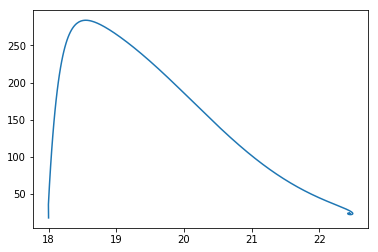

In [8]:
N=10000   #number of steps
dt=0.001 #time step in milliseconds
#prepare arrays. First we need to set an array of zeros with necessary size and then change its elements

T=zeros(N)  #array of times
V=zeros(N)  #array of potentials as function of time
C=zeros(N)  #array of calcium concentration

#initial potential and calcium concentration
V[0]=18
C[0]=18
#time constants in milliseconds
tauv=0.01
tauc=0.5

#threshold values for potential and calcium concentration
Vstar=15
Cstar=20

#number of neurons
n=50

g_v = 5
g_c = 5

off_set = 1

delV=10 #constant defining how strong neurons firing affect potential
delC=0.015 #constant defining how strong neurons firing affect calcium concentration
r=70  #rate of firing in Hz. Does not present in the equation in the paper because can be hidden in the redefinition of delV and delC

for i in range(N-1):  #numerical solution of the differential equation. This numerical method, called Newton's, is the most trivial and known for not working 
    #in some cases. We will start with it and later can compare with other, more sophisticated methods. You can google and try it yourself. 
    V[i+1]=(-V[i]/tauv + n*delV*r*(1/(1+exp((Vstar-V[i])/g_v)))*(1/(1+exp(C[i]-Cstar))) )*dt + V[i]  #step function is defined as sigmoid 1/(1+exp)
    C[i+1]=(-C[i]/tauc + delC*n*r*(1/(1+exp((Vstar-V[i])/g_c))))*dt + C[i]

plot(C,V) #we plot phase diagram concentration vs potential. 

### Chaos Example 

In [22]:
n=10
p = 0.5 #Probability of Connection 
M=getRandomConnectivity(n,p)
l=matrixOfEdges(M,n)

In [23]:
l

array([[2., 4., 6., 0., 0., 0., 0., 0., 0., 0.],
       [3., 7., 8., 9., 0., 0., 0., 0., 0., 0.],
       [8., 0., 1., 4., 5., 6., 7., 8., 9., 0.],
       [5., 0., 1., 7., 8., 9., 0., 0., 0., 0.],
       [4., 5., 6., 8., 9., 0., 0., 0., 0., 0.],
       [4., 1., 4., 7., 9., 0., 0., 0., 0., 0.],
       [7., 1., 2., 3., 4., 5., 8., 9., 0., 0.],
       [7., 0., 2., 4., 5., 6., 8., 9., 0., 0.],
       [6., 0., 1., 4., 6., 7., 9., 0., 0., 0.],
       [6., 1., 2., 3., 5., 6., 8., 0., 0., 0.]])

<function matplotlib.pyplot.show(*args, **kw)>

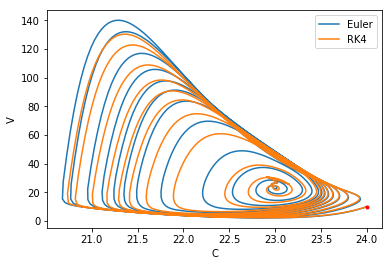

In [11]:
N=10000 #15000
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt

tauv=0.01 
tauc=0.5
Vstar=15
Cstar=20 
V0=10 #20
C0=24 #24

delV=12 #12
delC=0.015
r=70
r_0=5

g=1.
g_v = g #.95
g_c = g #.95

params=zeros(15)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=g_v
params[13]=g_c
params[14]=r_0

C2rk4,V2rk4 = simdynrk4(M, l, params)
C2,V2 = simdyn(M,l,params)
figure(1)
ylabel('V')
xlabel('C')
plot(C2,V2,label="Euler")
plot(C2rk4,V2rk4,label="RK4")
plot([C0],[V0],marker='o', markersize=3, color="red")
legend()
show

In [40]:
plot(T,V2rk4,label="RK4")
plot(T,V2,label="Euler")
legend()

In [99]:
print(C2rk4[N//2:])
print(V2rk4[N//2:])

[27.4778184  27.45595818 27.43149591 ... 27.55569395 27.55142731
 27.54449727]
[12.23347732 11.70725155 11.18642294 ... 15.87915748 15.31069241
 14.74884667]


<function matplotlib.pyplot.show(*args, **kw)>

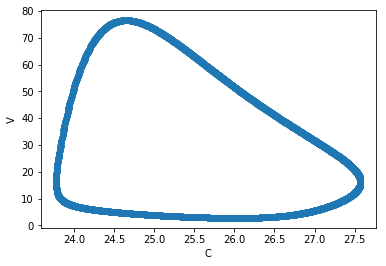

In [100]:
figure(1)
ylabel('V')
xlabel('C')
plot(C2[3*N//4:],V2[3*N//4:],'o',label="Runge Kutta")
show

In [116]:
classifier(C2, 1/dt, .01)

2

### Phase Diagrams

In [26]:
n=150 #100
n_min = 75 #1
p = .9 #Probability of Connection 

M=getRandomConnectivity(n,p)
l=matrixOfEdges(M,n)
M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)

In [30]:
### Set up network parameters 
N=1000000 #15000
dt=0.0005
T=zeros(N)
for i in range(N):
    T[i]=i*dt

to_cull = 0

tauv=0.01 
tauc=0.5
Vstar=15
Cstar=20 
V0=10 #20
C0=24 #24

delV=12. #12
delC=0.015
r=70
r_0=5

g_v = 0.5 #.95
g_c = 0.5 #.95
g = 0.1

params=zeros(15)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=g
params[13]=g
params[14]=r_0

### Set up phase space search 
phasen, phaseV, phaseC = [],[],[] #for plotting general, uninformative phase diagram
#phasen_SO_Q, phasen_Q_HA, phasen_SO_HA, phase_SO_Q, phase_Q_HA, phase_SO_HA = [],[],[],[],[],[]
dV = 0.1
delVmax = 4.5
to_cull = 0

phasen_SO_F,phasen_SO_C,phasen_F_C,phasen_F_SO,phasen_C_F,phasen_C_SO = [],[],[],[],[],[]
phase_SO_F,phase_SO_C,phase_F_C,phase_F_SO,phase_C_F,phase_C_SO = [],[],[],[],[],[]


while True:
    C,V = simdyn(M_prime,l_prime,params)
    #Crk4,Vrk4 = simdynrk4(M_prime,l_prime,params)
    check = classifier(C,1/dt,0.1)
    while True:
        params[1] -= 1
        to_cull += 1
        M_prime = killNeuron2(to_cull, M)
        l_prime = matrixOfEdges(M_prime, params[1])
        if params[1] <= n_min:
            params[12] += dV
            params[13] += dV
            params[1] = n
            to_cull = 0
            M_prime = copy.deepcopy(M)
            l_prime = copy.deepcopy(l)
            break
        C,V = simdyn(M_prime,l_prime,params)
        #Crk4,Vrk4 = simdynrk4(M_prime,l_prime,params)
        check2 = classifier(C,1/dt,0.1)
        if check2 != check:
            print("g: {}, n: {} ".format(params[12], params[1]))
            print("transition from", check, "to", check2)
            phasen.append(params[1])
            phaseV.append(params[12])
            
            if check == 0 and check2 == 1: 
                phasen_C_SO.append(params[1])
                phase_C_SO.append(params[12])
            elif check == 0 and check2 == 2:
                phasen_C_F.append(params[1])
                phase_C_F.append(params[12])
            elif check == 1 and check2 == 0: 
                phasen_SO_C.append(params[1])
                phase_SO_C.append(params[12])
            elif check == 1 and check2 == 2: 
                phasen_SO_F.append(params[1])
                phase_SO_F.append(params[12])
            elif check == 2 and check2 == 0: 
                phasen_F_C.append(params[1])
                phase_F_C.append(params[12])
            elif check == 2 and check2 == 1: 
                phasen_F_SO.append(params[1])
                phase_F_SO.append(params[12])
                
            params[12] += dV
            params[13] += dV
            
            if params[1] < n-3:
                to_cull -= 3
                params[1] += 3 #Changed from params[1] = n to track boundary 
                M_prime = killNeuron2(to_cull, M)
                l_prime = matrixOfEdges(M_prime, params[1])
            else:
                to_cull = 0
                params[1] = n 
                M_prime = copy.deepcopy(M)
                l_prime = copy.deepcopy(l)
            
            break
    
    if params[12] > delVmax:
        break
print('loop complete')


g: 0.1, n: 127.0 
transition from 2 to 1
g: 0.2, n: 123.0 
transition from 2 to 1
g: 0.4, n: 132.0 
transition from 2 to 1
g: 0.5, n: 128.0 
transition from 2 to 0
g: 0.8999999999999999, n: 139.0 
transition from 1 to 2
g: 0.9999999999999999, n: 119.0 
transition from 1 to 2
g: 1.0999999999999999, n: 105.0 
transition from 1 to 2
g: 1.2, n: 101.0 
transition from 1 to 2
g: 1.3, n: 94.0 
transition from 1 to 2
g: 1.4000000000000001, n: 88.0 
transition from 1 to 2
g: 1.5000000000000002, n: 87.0 
transition from 1 to 2
g: 1.6000000000000003, n: 86.0 
transition from 1 to 2
g: 1.7000000000000004, n: 84.0 
transition from 1 to 2
g: 1.8000000000000005, n: 84.0 
transition from 1 to 2
g: 1.9000000000000006, n: 83.0 
transition from 1 to 2
g: 2.0000000000000004, n: 83.0 
transition from 1 to 2
g: 2.1000000000000005, n: 82.0 
transition from 1 to 2
g: 2.2000000000000006, n: 82.0 
transition from 1 to 2
g: 2.3000000000000007, n: 82.0 
transition from 1 to 2
g: 2.400000000000001, n: 82.0 
transi

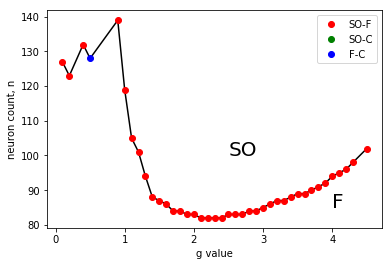

In [39]:
plot(phaseV,phasen,'k')
plot(phase_SO_F,phasen_SO_F,'ro',label='SO-F')
plot(phase_SO_C,phasen_SO_C,'go',label='SO-C')
plot(phase_F_C,phasen_F_C,'bo',label='F-C')
plot(phase_F_SO,phasen_F_SO,'ro')
plot(phase_C_F,phasen_C_F,'bo')
plot(phase_C_SO,phasen_C_SO,'go')
legend()
xlabel("g value")
ylabel("neuron count, n")
#ylim(70,110)
#text(0.5,75,"C",fontsize=20)
text(2.5,100,"SO",fontsize=20)
#text(0.5,105,"F",fontsize=20)
text(4.,85,"F",fontsize=20)
plt.savefig('figures/g_phase4.png',dpi=400)

Text(0.5, 1.0, '2')

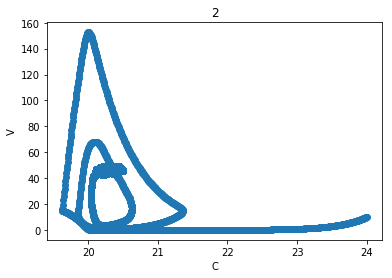

In [46]:
### Set up network parameters 
N=500000 #15000
dt=0.0001
T=zeros(N)
for i in range(N):
    T[i]=i*dt
    
target_n = 100#<--- Change to n value in phase diagram 

to_cull = n - target_n

tauv=0.01 
tauc=0.5
Vstar=15
Cstar=20 
V0=10 #20
C0=24 #24

delV=5. #12
delC=0.015
r=70
r_0=5

g_v = 0.5 #.95
g_c = 0.5 #.95
g = 0.01 #<--- Change to g value in phase diagram 

params=zeros(15)
params[0]=N
params[1]=target_n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=g
params[13]=g
params[14]=r_0

M_prime = killNeuron2(to_cull, M)
l_prime = matrixOfEdges(M_prime, params[1])
    

C,V = simdyn(M_prime, l_prime, params)
xlabel("C")
ylabel("V")



Text(0.5, 1.0, '2')

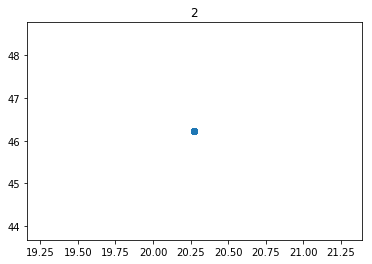

In [47]:
plot(C[-10000:],V[-10000:],'o')
#plot(C,V)
title(classifier(C,1/dt,0.1))

### Phase Diagram functions

In [17]:
def phase_diagram():
    pass

In [8]:
N=1000000 #15000
n=100
dt=0.0005
T=zeros(N)
for i in range(N):
    T[i]=i*dt

    
p = .9 #Probability of Connection 

tauv=0.01 
tauc=0.5
Vstar=15
Cstar=20 
V0=10 #20
C0=24 #24

delV=12. #12
delC=0.015
r=70
r_0=5

g_v = 0.5 #.95
g_c = 0.5 #.95
g = 1.5

params=zeros(15)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=g
params[13]=g
params[14]=r_0

C,V = simdyn(M,l,params)
plot(C[-1000:],V[-1000:])
classifier(V,1/dt,1)

NameError: name 'M' is not defined

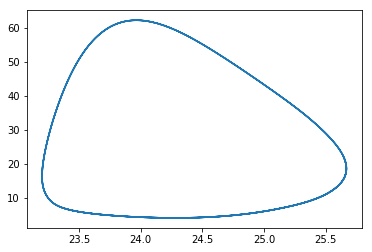

In [39]:
plot(C[-1000:],V[-1000:])

### Debugging

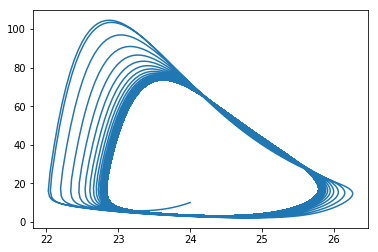

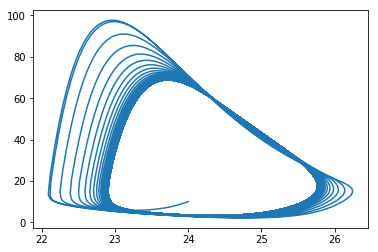

In [19]:
N=10000 #15000
n=100
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt

    
p = .9 #Probability of Connection 

#M=getRandomConnectivity(n,p)
#l=matrixOfEdges(M,n)
M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
to_cull = 0

tauv=0.01 
tauc=0.5
Vstar=15
Cstar=20 
V0=10 #20
C0=24 #24

delV=12. #12
delC=0.015
r=70
r_0=5

g_v = 0.5 #.95
g_c = 0.5 #.95
g = 1.15

params=zeros(15)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12]=g
params[13]=g
params[14]=r_0

C,V=simdyn(M,l,params)
Crk4,Vrk4=simdynrk4(M,l,params)
figure(1)
plot(C,V)
figure(2)
plot(Crk4,Vrk4)